### **This Notebook Uses PageRank to Weight Representative Spectra within each Surface**

This is done by building a similarity graph between each spectra, based on the Gaussian Kernel, then detecting the most representative spectra within each surface based on the PageRank centrality.

Import relevant libraries and import raw data

In [1]:
import seaborn as sns
import pandas as pd
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
os_name = os.name

if os_name == 'nt':
    password = os.getenv('NEO4J_Password')
    neo4j_directory = os.getenv('NEO4J_Directory')
else:
    password = os.environ['NEO4J_Password']
    neo4j_directory = os.environ['NEO4J_Directory']

In [3]:
df = pd.read_csv("../../data/current_clean_spectrum.csv")
full_df = df.copy()

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

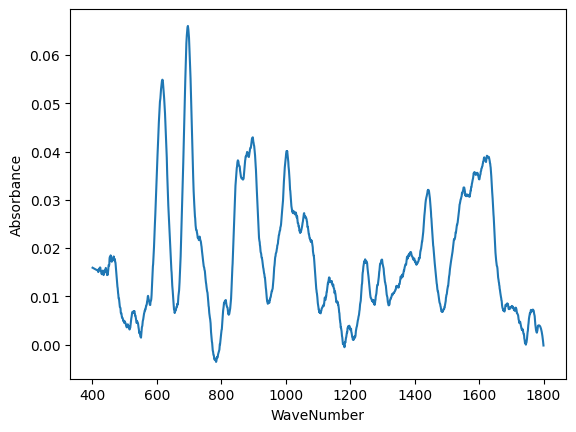

In [4]:
specid = "201210-1-00"
spectra = df[df['SpecID'] == specid]
spectra
sns.lineplot(data=spectra, x='WaveNumber', y="Absorbance", hue='SpecID', legend=False)

In [5]:
df['SurID'].unique()

array(['201210-1', '201210-2', '210114-1', '210114-2', '210120-1',
       '210120-2', '210121-1', '210121-2', '210211-1', '210211-2',
       '210217-1', '210217-2', '210218-1', '210224-1', '210225-1',
       '210225-2', '210303-1', '210303-2', '210304-1', '210304-2',
       '210310-1', '210310-2', '210311-1', '210311-2', '210315-1',
       '210315-2', '210318-1', '210318-2', '210324-1', '210324-2',
       '210325-1', '210325-2', '210331-1', '210401-1', '210415-1',
       '210415-2', '210419-1', '210419-2', '210421-1', '210407-1',
       '210407-2', '210414-1', '210414-3', '210414-2', '210428-1',
       '210428-2', '210428-3', '210429-1', '210504-1', '210504-2',
       '210504-3', '210505-1', '210510-1', '210510-2', '210511-1',
       '210518-1', '210519-1', '210519-2', '210519-3', '210524-1',
       '210526-1', '210526-2', '210526-3'], dtype=object)

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

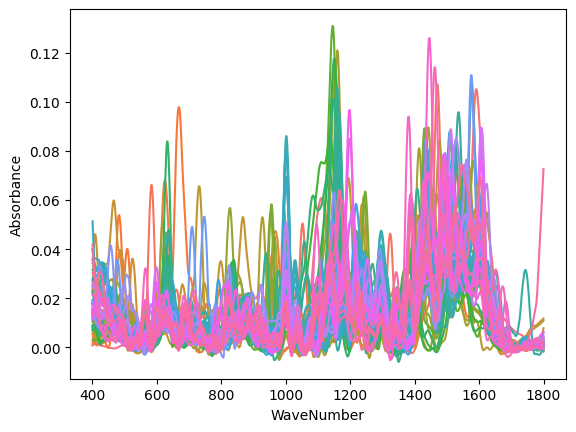

In [6]:
surface_id = "210324-1"
surface = df[df['SurID'] == surface_id]
surface
sns.lineplot(data=surface, x='WaveNumber', y="Absorbance", hue='SpecID', legend=False)

In [7]:
#sns.lineplot(data=df, x='WaveNumber', y='Absorbance', hue='Status', errorbar=('ci', False))

In [8]:
sample = df[df['SurID'] == '210526-3']

In [9]:
#sns.lineplot(data=sample, x='WaveNumber', y='Absorbance', hue='Status', errorbar=('ci', False))

In [10]:
df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance
0,201210-1-00,293,400.22778,201210-1,Normal,0.015937
1,201210-1-00,294,400.91116,201210-1,Normal,0.015915
2,201210-1-00,295,401.59454,201210-1,Normal,0.015891
3,201210-1-00,296,402.27789,201210-1,Normal,0.015867
4,201210-1-00,297,402.96127,201210-1,Normal,0.015841
...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,210526-3,Hyperglycemia,0.004530
6239201,210526-3-09,2338,1797.72200,210526-3,Hyperglycemia,0.004856
6239202,210526-3-09,2339,1798.40550,210526-3,Hyperglycemia,0.005196
6239203,210526-3-09,2340,1799.08890,210526-3,Hyperglycemia,0.005550


In [11]:
pivoted_df = df.pivot(index='SpecID', columns='WaveNumber', values='Absorbance').reset_index()
pivoted_df.columns.name = None

statuses = df[['SpecID', 'Status']].drop_duplicates()

pivoted_df = pd.merge(pivoted_df, statuses, on='SpecID')
pivoted_df = pivoted_df.set_index('SpecID')

pivoted_df.head()

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,1794.3053,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,0.015937,0.015915,0.015891,0.015867,0.015841,0.015816,0.015789,0.015763,0.015736,0.015709,...,0.002643,0.002391,0.002113,0.001807,0.001472,0.001108,0.000712,0.000285,-0.000175,Normal
201210-1-01,0.013765,0.014065,0.014355,0.014635,0.014905,0.015165,0.015416,0.015657,0.015888,0.016110,...,0.001879,0.002012,0.002164,0.002336,0.002530,0.002746,0.002985,0.003247,0.003535,Normal
201210-1-02,0.013503,0.013107,0.012750,0.012431,0.012149,0.011903,0.011689,0.011508,0.011356,0.011233,...,-0.000534,-0.000530,-0.000521,-0.000507,-0.000489,-0.000466,-0.000438,-0.000404,-0.000365,Normal
201210-1-03,0.013512,0.013464,0.013413,0.013360,0.013305,0.013248,0.013191,0.013132,0.013073,0.013014,...,-0.000863,-0.000831,-0.000796,-0.000759,-0.000719,-0.000677,-0.000632,-0.000586,-0.000537,Normal
201210-1-04,0.026276,0.025058,0.023939,0.022915,0.021985,0.021143,0.020387,0.019713,0.019118,0.018598,...,-0.002726,-0.002747,-0.002762,-0.002770,-0.002773,-0.002769,-0.002759,-0.002742,-0.002720,Normal


In [12]:
status_df = df.groupby('SpecID')[['SurID', 'Status']].first()
# surface_and_status.to_csv("../../data/surface_and_status.csv")
status_df

,SurID,Status
SpecID,,
201210-1-00,201210-1,Normal
201210-1-01,201210-1,Normal
201210-1-02,201210-1,Normal
201210-1-03,201210-1,Normal
201210-1-04,201210-1,Normal
...,...,...
210526-3-45,210526-3,Hyperglycemia
210526-3-46,210526-3,Hyperglycemia
210526-3-47,210526-3,Hyperglycemia


>#### **Calculate an adjacency matrix using a Gaussian Kernel**

In [13]:
from scipy.spatial.distance import pdist, squareform

# Drop the 'Status' column as it is not numeric
X = pivoted_df.drop(columns=['Status'])

# Calculate pairwise Euclidean distances
distances = pdist(X.values, metric='euclidean')

# Convert the condensed distances to a square matrix form
distance_matrix = squareform(distances)

In [47]:
def gaussian_kernel(distances, sigma):
    return np.exp(-distances**2 / (2 * sigma**2))

# Sigma is the bandwidth parameter
sigma = 0.5 # Adjust sigma as needed
kernel_matrix = gaussian_kernel(distance_matrix, sigma)

# Convert the kernel matrix to a DataFrame
kernel_df = pd.DataFrame(kernel_matrix, index=pivoted_df.index, columns=pivoted_df.index)

display(kernel_df.head())
kernel_df.shape

SpecID,201210-1-00,201210-1-01,201210-1-02,201210-1-03,201210-1-04,201210-1-05,201210-1-06,201210-1-07,201210-1-09,201210-1-10,...,210526-3-40,210526-3-41,210526-3-42,210526-3-43,210526-3-44,210526-3-45,210526-3-46,210526-3-47,210526-3-48,210526-3-49
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,1.000000,0.843070,0.252118,0.254183,0.594585,0.496502,0.388216,0.428120,0.470017,0.525490,...,0.529679,0.524188,0.467818,0.520294,0.549522,0.539496,0.537456,0.540950,0.554101,0.522791
201210-1-01,0.843070,1.000000,0.309668,0.268638,0.660532,0.562650,0.451611,0.471978,0.503098,0.531074,...,0.502951,0.505360,0.451361,0.495833,0.517492,0.511794,0.518061,0.520174,0.528624,0.489910
201210-1-02,0.252118,0.309668,1.000000,0.364753,0.169234,0.157452,0.133330,0.156034,0.180236,0.171952,...,0.112372,0.115465,0.108588,0.114292,0.117849,0.115060,0.121365,0.145315,0.124976,0.114570
201210-1-03,0.254183,0.268638,0.364753,1.000000,0.166796,0.157208,0.166993,0.198737,0.227509,0.208619,...,0.171819,0.182321,0.159902,0.170831,0.176212,0.172563,0.177624,0.211789,0.194752,0.174324
201210-1-04,0.594585,0.660532,0.169234,0.166796,1.000000,0.879629,0.577207,0.544180,0.530981,0.587144,...,0.501024,0.497540,0.445696,0.499144,0.496562,0.501935,0.523855,0.504576,0.506249,0.497993


(3045, 3045)

**Construct the node and edge import files with the required Admin Import Headers**

In [48]:
relationship_df = kernel_df.reset_index()
relationship_df = relationship_df.melt(id_vars='SpecID', var_name=':END_ID', value_name='Weight:float')
relationship_df = relationship_df.rename(columns={'SpecID': ':START_ID'})
relationship_df[':TYPE'] = 'LINK'

Drop Relationships a node has with itself, along with repeat relationships.

In [49]:
relationship_df = relationship_df[relationship_df[":START_ID"] != relationship_df[":END_ID"]]
relationship_df = relationship_df[relationship_df[":START_ID"] < relationship_df[":END_ID"]]  # Drops redundant relationships
relationship_df

,:START_ID,:END_ID,Weight:float,:TYPE
3045,201210-1-00,201210-1-01,0.843070,LINK
6090,201210-1-00,201210-1-02,0.252118,LINK
6091,201210-1-01,201210-1-02,0.309668,LINK
9135,201210-1-00,201210-1-03,0.254183,LINK
9136,201210-1-01,201210-1-03,0.268638,LINK
...,...,...,...,...
9272019,210526-3-44,210526-3-49,0.943195,LINK
9272020,210526-3-45,210526-3-49,0.928391,LINK
9272021,210526-3-46,210526-3-49,0.944954,LINK
9272022,210526-3-47,210526-3-49,0.919646,LINK


In [50]:
node_df = status_df.reset_index()
node_df.rename(columns={'SpecID':'SpecID:ID', 'Status':'Status:LABEL', 'SurID':'SurID:LABEL'}, inplace=True)
node_df

,SpecID:ID,SurID:LABEL,Status:LABEL
0,201210-1-00,201210-1,Normal
1,201210-1-01,201210-1,Normal
2,201210-1-02,201210-1,Normal
3,201210-1-03,201210-1,Normal
4,201210-1-04,201210-1,Normal
...,...,...,...
3040,210526-3-45,210526-3,Hyperglycemia
3041,210526-3-46,210526-3,Hyperglycemia
3042,210526-3-47,210526-3,Hyperglycemia
3043,210526-3-48,210526-3,Hyperglycemia


In [51]:
node_df.to_csv(f"{neo4j_directory}/import/nodes.csv", index=False)

In [52]:
relationship_df.to_csv(f"{neo4j_directory}/import/relationships.csv", index=False)

In [53]:
from neo4j import GraphDatabase
import os
import pandas as pd
import shutil
import subprocess

---

### **Neo4J Queries**

This moves the nodes and relationships files from data/current_working_graph into the DBMS import folder.

At the moment this uses local paths, but the rest should be automated.

Then run the admin import command.

In [54]:
os_name = os.name

if os_name == 'nt':
    working_dir = f'{neo4j_directory}/bin'
    command = 'neo4j-admin database import full --nodes=import/nodes.csv --relationships=import/relationships.csv --overwrite-destination neo4j'
    result = subprocess.run(command, shell=True, cwd=working_dir, capture_output=True, text=True)
else:
    working_dir = f'{neo4j_directory}'
    command = [
    './bin/neo4j-admin', 'database', 'import', 'full',
    '--nodes=import/nodes.csv',
    '--relationships=import/relationships.csv',
    '--overwrite-destination',  'neo4j'
    ]
    result = subprocess.run(command, cwd=working_dir, stdout=subprocess.PIPE, stderr=subprocess.PIPE)


# Check if the command was successful
if result.returncode == 0:
    print("Import successful")
    print(result.stdout)
else:
    print("Error during import:")
    print(result.stderr)

Import successful
b"Neo4j version: 5.12.0\nImporting the contents of these files into /home/eddie/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-e4c1e17b-4cb7-4b84-a9fb-3fde3105cb8a/data/databases/neo4j:\nNodes:\n  /home/eddie/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-e4c1e17b-4cb7-4b84-a9fb-3fde3105cb8a/import/nodes.csv\n\nRelationships:\n  /home/eddie/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-e4c1e17b-4cb7-4b84-a9fb-3fde3105cb8a/import/relationships.csv\n\n\nAvailable resources:\n  Total machine memory: 13.49GiB\n  Free machine memory: 2.058GiB\n  Max heap memory : 910.5MiB\n  Max worker threads: 12\n  Configured max memory: 1.088GiB\n  High parallel IO: true\n\nCypher type normalization is enabled (disable with --normalize-types=false):\n  Property type of 'Weight' normalized from 'float' --> 'double' in /home/eddie/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-e4c1e17b-4cb7-4b84-a9fb-3fde3105cb8a/import/relationships.csv\n\nImport 

In [55]:
if os_name != 'nt':
    command = [
        './bin/neo4j', 'restart'
    ]

    result = subprocess.run(command, cwd=neo4j_directory, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

    # Check if the command was successful
    if result.returncode == 0:
        print("Restart successful")
        print(result.stdout)
    else:
        print("Error during restart:")
        print(result.stderr)

Restart successful
b'Stopping Neo4j........ stopped.\nConfiguration file validation successful (with warnings).\nDirectories in use:\nhome:         /home/eddie/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-e4c1e17b-4cb7-4b84-a9fb-3fde3105cb8a\nconfig:       /home/eddie/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-e4c1e17b-4cb7-4b84-a9fb-3fde3105cb8a/conf\nlogs:         /home/eddie/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-e4c1e17b-4cb7-4b84-a9fb-3fde3105cb8a/logs\nplugins:      /home/eddie/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-e4c1e17b-4cb7-4b84-a9fb-3fde3105cb8a/plugins\nimport:       /home/eddie/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-e4c1e17b-4cb7-4b84-a9fb-3fde3105cb8a/import\ndata:         /home/eddie/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-e4c1e17b-4cb7-4b84-a9fb-3fde3105cb8a/data\ncertificates: /home/eddie/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-e4c1e17b-4cb7-4b84-a9fb-3fd

Run and connect to the Neo4j Database

In [56]:
from neo4j import GraphDatabase

uri = "neo4j://localhost:7687"
username = "neo4j"              # Neo4J username
#Password defined at the top of the notebook

# Create a driver instance
driver = GraphDatabase.driver(uri, auth=(username, password))

# Ensure you close the driver connection when your program ends
def close_driver():
    driver.close()

**We will calculate the centrality rank of each spectra within it's surface**

In [57]:
surfaces = status_df['SurID'].unique()
surfaces

array(['201210-1', '201210-2', '210114-1', '210114-2', '210120-1',
       '210120-2', '210121-1', '210121-2', '210211-1', '210211-2',
       '210217-1', '210217-2', '210218-1', '210224-1', '210225-1',
       '210225-2', '210303-1', '210303-2', '210304-1', '210304-2',
       '210310-1', '210310-2', '210311-1', '210311-2', '210315-1',
       '210315-2', '210318-1', '210318-2', '210324-1', '210324-2',
       '210325-1', '210325-2', '210331-1', '210401-1', '210407-1',
       '210407-2', '210414-1', '210414-2', '210414-3', '210415-1',
       '210415-2', '210419-1', '210419-2', '210421-1', '210428-1',
       '210428-2', '210428-3', '210429-1', '210504-1', '210504-2',
       '210504-3', '210505-1', '210510-1', '210510-2', '210511-1',
       '210518-1', '210519-1', '210519-2', '210519-3', '210524-1',
       '210526-1', '210526-2', '210526-3'], dtype=object)

In [58]:
pagerank_dfs = []

def project_graph(tx, surface):
    query = """
    CALL gds.graph.project(
      'myGraph', 
      $nodeLabel,
      {
        LINK: {
          orientation: 'UNDIRECTED',
          properties: 'Weight'
        }
      }
    )
    """
    tx.run(query, nodeLabel=surface)

def delete_projection(tx):
    query = """
    CALL gds.graph.drop('myGraph')
    """
    tx.run(query)

def run_pagerank_centrality(tx):
    query = """
    CALL gds.pageRank.stream('myGraph', {
        relationshipWeightProperty: 'Weight'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["score"]) for record in results]

# scaler = StandardScaler()
scaler = MinMaxScaler()
for surface in surfaces:
    with driver.session() as session:
        session.execute_write(project_graph, surface)
        pagerank_results = session.execute_read(run_pagerank_centrality)
        pagerank_df = pd.DataFrame(pagerank_results, columns=['name', 'PageRank'])
        pagerank_df['SurfacePageRankRank'] = pagerank_df['PageRank'].rank(method='dense', ascending=False)  # Get the rank of centrality of each spectra within the surface
        pagerank_df['ReverseSurfacePageRankRank'] = pagerank_df['PageRank'].rank(method='dense')  # Get the rank of centrality of each spectra within the surface
        pagerank_df['ScaledPageRank'] = scaler.fit_transform(pagerank_df[['PageRank']]) # Scale the pagerank in each surface
        pagerank_dfs.append(pagerank_df)
        session.execute_write(delete_projection)


Unable to retrieve routing information
Transaction failed and will be retried in 1.056625448759311s (Unable to retrieve routing information)


Unable to retrieve routing information
Transaction failed and will be retried in 2.0517603944831624s (Unable to retrieve routing information)
Unable to retrieve routing information
Transaction failed and will be retried in 3.9114913914501406s (Unable to retrieve routing information)
Unable to retrieve routing information
Transaction failed and will be retried in 8.009958072079298s (Unable to retrieve routing information)


In [59]:
close_driver()

In [60]:
pagerank_results = pd.concat(pagerank_dfs).rename(columns={'name':'SpecID'})
pagerank_results

,SpecID,PageRank,SurfacePageRankRank,ReverseSurfacePageRankRank,ScaledPageRank
0,201210-1-39,1.087218,1.0,49.0,1.000000
1,201210-1-47,1.080051,2.0,48.0,0.989718
2,201210-1-49,1.078119,3.0,47.0,0.986946
3,201210-1-46,1.071705,4.0,46.0,0.977744
4,201210-1-43,1.070778,5.0,45.0,0.976414
...,...,...,...,...,...
45,210526-3-06,0.791503,46.0,5.0,0.568776
46,210526-3-04,0.771703,47.0,4.0,0.536618
47,210526-3-01,0.557895,48.0,3.0,0.189348
48,210526-3-32,0.542488,49.0,2.0,0.164325


##### **Test how different Centrality Ranks affect Predictive Performance**

In [61]:
from sklearn.model_selection import cross_validate, GroupKFold
from sklearn.ensemble import ExtraTreesClassifier

In [62]:
df = full_df
df = df.merge(pagerank_results, on='SpecID')
df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance,PageRank,SurfacePageRankRank,ReverseSurfacePageRankRank,ScaledPageRank
0,201210-1-00,293,400.22778,201210-1,Normal,0.015937,0.925720,38.0,12.0,0.768302
1,201210-1-00,294,400.91116,201210-1,Normal,0.015915,0.925720,38.0,12.0,0.768302
2,201210-1-00,295,401.59454,201210-1,Normal,0.015891,0.925720,38.0,12.0,0.768302
3,201210-1-00,296,402.27789,201210-1,Normal,0.015867,0.925720,38.0,12.0,0.768302
4,201210-1-00,297,402.96127,201210-1,Normal,0.015841,0.925720,38.0,12.0,0.768302
...,...,...,...,...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,210526-3,Hyperglycemia,0.004530,1.001984,29.0,22.0,0.910641
6239201,210526-3-09,2338,1797.72200,210526-3,Hyperglycemia,0.004856,1.001984,29.0,22.0,0.910641
6239202,210526-3-09,2339,1798.40550,210526-3,Hyperglycemia,0.005196,1.001984,29.0,22.0,0.910641
6239203,210526-3-09,2340,1799.08890,210526-3,Hyperglycemia,0.005550,1.001984,29.0,22.0,0.910641


In [63]:
df['PageRank'].describe()

count    6.239205e+06
mean     9.612405e-01
std      1.543399e-01
min      2.325289e-01
25%      9.188502e-01
50%      9.830442e-01
75%      1.059456e+00
max      1.259256e+00
Name: PageRank, dtype: float64

In [64]:
def prepare_wavelength_df(df, absorbance_col, status_col='Status', include_pagerank=False, include_scaled_pagerank=False):

    # Pivot the DataFrame to get wavelengths as columns and absorbance values
    wavelength_df = df.pivot(index='SpecID', columns='WaveNumber', values=absorbance_col).reset_index()
    wavelength_df.columns.name = None

    # Merge with the statuses based on SpecID
    # Include the SurID to perform GroupKFold CV
    statuses_and_surface = df[['SpecID', 'SurID', status_col]].drop_duplicates()
    wavelength_df = pd.merge(wavelength_df, statuses_and_surface, on='SpecID')

    if include_pagerank:
        wavelength_df = pd.merge(wavelength_df, df[['SpecID', 'PageRank']].drop_duplicates(), on='SpecID', how='left')

    if include_scaled_pagerank:
        wavelength_df = pd.merge(wavelength_df, df[['SpecID', 'ScaledPageRank']].drop_duplicates(), on='SpecID', how='left')

    # Set SpecID as the index
    wavelength_df = wavelength_df.set_index('SpecID')

    return wavelength_df

In [65]:
def evaluate_extra_trees(df, pagerank_weights=False, scaled_pagerank_weights=False):

    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']

    # Creating the Extra Trees classifier
    et = ExtraTreesClassifier(random_state=1234)
    
    # Using GroupKFold for classification tasks
    cv = GroupKFold(n_splits=10)

    if pagerank_weights:
        X = X.drop(['PageRank'], axis=1)
        weights = df['PageRank']
        scores = cross_validate(et, X, y, groups=groups, cv=cv, params={'sample_weight': weights}, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'])

    elif scaled_pagerank_weights:
        X = X.drop(['ScaledPageRank'], axis=1)
        weights = df['ScaledPageRank']
        scores = cross_validate(et, X, y, groups=groups, cv=cv, params={'sample_weight': weights}, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'])

    else:
        scores = cross_validate(et, X, y, groups=groups, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'])

    # Displaying the results
    print(f"{et.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores['test_accuracy']):.4f} +/- {np.std(scores['test_accuracy']):.4f}")
    print(f"{et.__class__.__name__} Cross-Validation Precision: {np.mean(scores['test_precision_macro']):.4f} +/- {np.std(scores['test_precision_macro']):.4f}")
    print(f"{et.__class__.__name__} Cross-Validation Recall: {np.mean(scores['test_recall_macro']):.4f} +/- {np.std(scores['test_recall_macro']):.4f}")
    print(f"{et.__class__.__name__} Cross-Validation F1-Score: {np.mean(scores['test_f1_macro']):.4f} +/- {np.std(scores['test_f1_macro']):.4f}")

In [66]:
wavelength_df = prepare_wavelength_df(df, 'Absorbance')

In [67]:
wavelength_df

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,SurID,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,0.015937,0.015915,0.015891,0.015867,0.015841,0.015816,0.015789,0.015763,0.015736,0.015709,...,0.002391,0.002113,0.001807,0.001472,0.001108,0.000712,0.000285,-0.000175,201210-1,Normal
201210-1-01,0.013765,0.014065,0.014355,0.014635,0.014905,0.015165,0.015416,0.015657,0.015888,0.016110,...,0.002012,0.002164,0.002336,0.002530,0.002746,0.002985,0.003247,0.003535,201210-1,Normal
201210-1-02,0.013503,0.013107,0.012750,0.012431,0.012149,0.011903,0.011689,0.011508,0.011356,0.011233,...,-0.000530,-0.000521,-0.000507,-0.000489,-0.000466,-0.000438,-0.000404,-0.000365,201210-1,Normal
201210-1-03,0.013512,0.013464,0.013413,0.013360,0.013305,0.013248,0.013191,0.013132,0.013073,0.013014,...,-0.000831,-0.000796,-0.000759,-0.000719,-0.000677,-0.000632,-0.000586,-0.000537,201210-1,Normal
201210-1-04,0.026276,0.025058,0.023939,0.022915,0.021985,0.021143,0.020387,0.019713,0.019118,0.018598,...,-0.002747,-0.002762,-0.002770,-0.002773,-0.002769,-0.002759,-0.002742,-0.002720,201210-1,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210526-3-45,0.006010,0.006559,0.007035,0.007442,0.007783,0.008062,0.008283,0.008449,0.008564,0.008632,...,0.003644,0.003931,0.004212,0.004485,0.004749,0.005004,0.005248,0.005480,210526-3,Hyperglycemia
210526-3-46,0.007997,0.007636,0.007290,0.006962,0.006651,0.006358,0.006086,0.005833,0.005602,0.005393,...,0.001193,0.001527,0.001913,0.002354,0.002851,0.003409,0.004028,0.004712,210526-3,Hyperglycemia
210526-3-47,0.010315,0.010426,0.010490,0.010513,0.010496,0.010444,0.010359,0.010246,0.010107,0.009946,...,0.004144,0.004652,0.005188,0.005752,0.006344,0.006965,0.007613,0.008288,210526-3,Hyperglycemia


In [68]:
evaluate_extra_trees(wavelength_df)

/home/eddie/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ExtraTreesClassifier Cross-Validation Accuracy: 0.5811 +/- 0.1061
ExtraTreesClassifier Cross-Validation Precision: 0.5928 +/- 0.1048
ExtraTreesClassifier Cross-Validation Recall: 0.5968 +/- 0.1480
ExtraTreesClassifier Cross-Validation F1-Score: 0.5603 +/- 0.1221


##### **I'll try using the Surface PageRank as a sample weight**

In [76]:
wavelength_df = prepare_wavelength_df(df, 'Absorbance', include_pagerank=True)
wavelength_df

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,SurID,Status,PageRank
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,0.015937,0.015915,0.015891,0.015867,0.015841,0.015816,0.015789,0.015763,0.015736,0.015709,...,0.002113,0.001807,0.001472,0.001108,0.000712,0.000285,-0.000175,201210-1,Normal,0.925720
201210-1-01,0.013765,0.014065,0.014355,0.014635,0.014905,0.015165,0.015416,0.015657,0.015888,0.016110,...,0.002164,0.002336,0.002530,0.002746,0.002985,0.003247,0.003535,201210-1,Normal,0.864825
201210-1-02,0.013503,0.013107,0.012750,0.012431,0.012149,0.011903,0.011689,0.011508,0.011356,0.011233,...,-0.000521,-0.000507,-0.000489,-0.000466,-0.000438,-0.000404,-0.000365,201210-1,Normal,0.390198
201210-1-03,0.013512,0.013464,0.013413,0.013360,0.013305,0.013248,0.013191,0.013132,0.013073,0.013014,...,-0.000796,-0.000759,-0.000719,-0.000677,-0.000632,-0.000586,-0.000537,201210-1,Normal,0.419339
201210-1-04,0.026276,0.025058,0.023939,0.022915,0.021985,0.021143,0.020387,0.019713,0.019118,0.018598,...,-0.002762,-0.002770,-0.002773,-0.002769,-0.002759,-0.002742,-0.002720,201210-1,Normal,0.746538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210526-3-45,0.006010,0.006559,0.007035,0.007442,0.007783,0.008062,0.008283,0.008449,0.008564,0.008632,...,0.003931,0.004212,0.004485,0.004749,0.005004,0.005248,0.005480,210526-3,Hyperglycemia,1.034013
210526-3-46,0.007997,0.007636,0.007290,0.006962,0.006651,0.006358,0.006086,0.005833,0.005602,0.005393,...,0.001527,0.001913,0.002354,0.002851,0.003409,0.004028,0.004712,210526-3,Hyperglycemia,1.040195
210526-3-47,0.010315,0.010426,0.010490,0.010513,0.010496,0.010444,0.010359,0.010246,0.010107,0.009946,...,0.004652,0.005188,0.005752,0.006344,0.006965,0.007613,0.008288,210526-3,Hyperglycemia,1.022892


In [70]:
evaluate_extra_trees(wavelength_df, pagerank_weights=True)

/home/eddie/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ExtraTreesClassifier Cross-Validation Accuracy: 0.5725 +/- 0.0988
ExtraTreesClassifier Cross-Validation Precision: 0.5851 +/- 0.1039
ExtraTreesClassifier Cross-Validation Recall: 0.5898 +/- 0.1399
ExtraTreesClassifier Cross-Validation F1-Score: 0.5517 +/- 0.1164


In [80]:
wavelength_df['PageRank'] = wavelength_df['PageRank'] * 1000
evaluate_extra_trees(wavelength_df, pagerank_weights=True)

/home/eddie/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ExtraTreesClassifier Cross-Validation Accuracy: 0.5783 +/- 0.0998
ExtraTreesClassifier Cross-Validation Precision: 0.5889 +/- 0.1011
ExtraTreesClassifier Cross-Validation Recall: 0.5937 +/- 0.1430
ExtraTreesClassifier Cross-Validation F1-Score: 0.5574 +/- 0.1162


##### **Scaled PageRank**

In [72]:
wavelength_df = prepare_wavelength_df(df, 'Absorbance', include_scaled_pagerank=True)
wavelength_df

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,SurID,Status,ScaledPageRank
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,0.015937,0.015915,0.015891,0.015867,0.015841,0.015816,0.015789,0.015763,0.015736,0.015709,...,0.002113,0.001807,0.001472,0.001108,0.000712,0.000285,-0.000175,201210-1,Normal,0.768302
201210-1-01,0.013765,0.014065,0.014355,0.014635,0.014905,0.015165,0.015416,0.015657,0.015888,0.016110,...,0.002164,0.002336,0.002530,0.002746,0.002985,0.003247,0.003535,201210-1,Normal,0.680938
201210-1-02,0.013503,0.013107,0.012750,0.012431,0.012149,0.011903,0.011689,0.011508,0.011356,0.011233,...,-0.000521,-0.000507,-0.000489,-0.000466,-0.000438,-0.000404,-0.000365,201210-1,Normal,0.000000
201210-1-03,0.013512,0.013464,0.013413,0.013360,0.013305,0.013248,0.013191,0.013132,0.013073,0.013014,...,-0.000796,-0.000759,-0.000719,-0.000677,-0.000632,-0.000586,-0.000537,201210-1,Normal,0.041808
201210-1-04,0.026276,0.025058,0.023939,0.022915,0.021985,0.021143,0.020387,0.019713,0.019118,0.018598,...,-0.002762,-0.002770,-0.002773,-0.002769,-0.002759,-0.002742,-0.002720,201210-1,Normal,0.511233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210526-3-45,0.006010,0.006559,0.007035,0.007442,0.007783,0.008062,0.008283,0.008449,0.008564,0.008632,...,0.003931,0.004212,0.004485,0.004749,0.005004,0.005248,0.005480,210526-3,Hyperglycemia,0.962664
210526-3-46,0.007997,0.007636,0.007290,0.006962,0.006651,0.006358,0.006086,0.005833,0.005602,0.005393,...,0.001527,0.001913,0.002354,0.002851,0.003409,0.004028,0.004712,210526-3,Hyperglycemia,0.972704
210526-3-47,0.010315,0.010426,0.010490,0.010513,0.010496,0.010444,0.010359,0.010246,0.010107,0.009946,...,0.004652,0.005188,0.005752,0.006344,0.006965,0.007613,0.008288,210526-3,Hyperglycemia,0.944601


In [73]:
evaluate_extra_trees(wavelength_df, scaled_pagerank_weights=True)

/home/eddie/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ExtraTreesClassifier Cross-Validation Accuracy: 0.5807 +/- 0.1010
ExtraTreesClassifier Cross-Validation Precision: 0.5952 +/- 0.1033
ExtraTreesClassifier Cross-Validation Recall: 0.5984 +/- 0.1417
ExtraTreesClassifier Cross-Validation F1-Score: 0.5611 +/- 0.1179
